In [1]:
from brian2 import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
import pandas as pd
import pickle
from loaders import DurationExperiment

from utils import *
from almodel import *

plt.style.use('pcb')

In [2]:
def find_end(spiketrain, duration, start=2, min_duration=0.03):
    duration = max(duration, min_duration)
    isis = np.diff(spiketrain)
    end = (spiketrain[:-1][((spiketrain[1:] > start+duration) & (isis > 0.1))])[0]
    return end - start

def mean_end(SM, from_dict=False, *args, **kwargs):
    tarr = np.arange(0, 8, 1e-3)

    ends = []
    
    if from_dict:
        iterable = SM.items()
    else:
        iterable = SM.spike_trains().items()
        
    for i, spike_train in iterable:
        st = spike_train / second
        ends.append(find_end(st, *args, **kwargs))

    ends = np.array(ends)

    return ends.mean()

In [3]:
res_complet = pickle.load( open( "data/generated/al_results.pickle", "rb" ) )

In [4]:
kdes_trials = pickle.load( open( "data/generated/al_kdes.pickle", "rb" ) )

In [5]:
ends = {}
durations_num = np.array([int(dur[:-2])/1000 for dur in durations])

for dur, dur_num in zip(durations, durations_num):
    ends[dur] = []

    for res in res_complet[dur]:
        try:
            ends[dur].append(mean_end(res, from_dict=True, duration=dur_num))
        except:
            ends[dur].append(np.nan)

In [6]:
mean_ends = []

for dur in durations:
    mean_ends.append(np.nanmean(ends[dur]))
    
mean_ends = np.array(mean_ends)

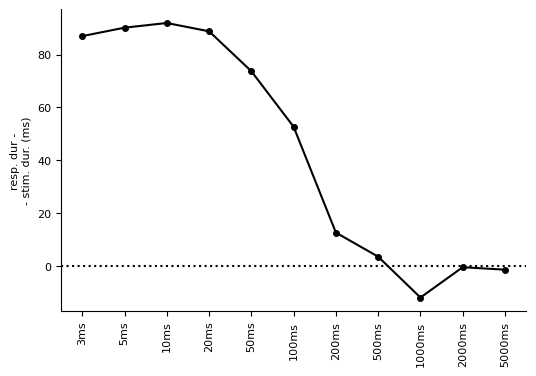

In [7]:
fig, ax = plt.subplots()

def plot_overdurations(ax):
    ax.plot((mean_ends - durations_num)*1000, marker='o', ms=4, color='black')
    ax.set_xticks(range(len(durations_num)))
    ax.set_xticklabels(durations, rotation=90);

    ax.axhline(0, linestyle='dotted', color='black')
    ax.set_ylabel('resp. dur -\n- stim. dur. (ms)')
    
plot_overdurations(ax)

In [8]:
stim_arrs = {}

for dur in durations:
    stim_arr = get_stim_arr(dur)
    t_arr = np.arange(len(stim_arr))*1e-4
    stim_arrs[dur] = (t_arr, stim_arr)

WARNING    /tmp/ipykernel_3743/2004778135.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[-1].set_xticklabels([f'{xt-7:.1f}' for xt in xticks])
 [py.warnings]


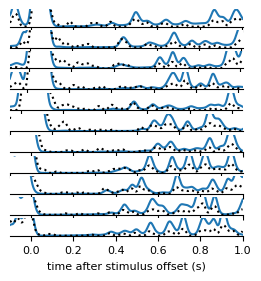

In [11]:
def rescale(arr):
    return arr / arr.max()

def plot_pn_shapes(axes, text_x=1.99, text_y=4, xlims=None, durs=None, add_text=True):
    tarr = np.arange(0, 10, 1e-3)
    
    if xlims is None:
        xlims = (1.9, 2.3), (1.9, 2.5), (1.9, 4.5)
    if durs is None:
        durs = ['20ms','200ms','2000ms']
    
    bar_height = 195
    
    for i, (dur_str, ax, xlim) in enumerate(zip(durs, axes, xlims)):
        dur = int(dur_str[:-2]) / 1000
        kde_pn = np.mean(kdes_trials[dur_str], axis=0)

        ax.plot(tarr, kde_pn, label='avg PN')
        t_arr, stim_arr = stim_arrs[dur_str]
        ax.plot(t_arr, rescale(stim_arr)*kde_pn.max(), color='black', linestyle='dotted', label='ORN shape')

        ax.set_xlim(xlim)
        
        if add_text:
            ax.plot([2, 2.+dur], [195, 195], lw=3, color='black')
            ax.text(text_x, bar_height+text_y, f'{dur*1000:.0f}ms')
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])
            ax.set_ylim(0, 200)

            if i == 0:
                ax.set_ylabel('spikes / s')
            else:
                despine_ax(ax, remove_ticks=True)
    
fig, axes = plt.subplots(nrows=len(durations), figsize=(3,3))

def plot_pn_inhib(axes):
    tarr = np.arange(0, 10, 1e-3)
    
    xlims = []
    for dur_str in durations:
        dur = int(dur_str[:-2]) / 1000
        x_start = 2 + dur - 0.1
        x_end = 2 + dur + 1
        xlims.append((x_start, x_end))

    plot_pn_shapes(axes, xlims=xlims, durs=durations, add_text=False)
    for i, ax in enumerate(axes):
        ax.set_ylim(0,20)
        despine_ax(ax, where='l')
        if i != len(durations)-1:
            ax.set_xticklabels([])

    xticks = np.array(axes[-1].get_xticks())
    axes[-1].set_xticklabels([f'{xt-7:.1f}' for xt in xticks])
    axes[-1].set_xlabel('time after stimulus offset (s)')
    # ax.legend()
    
plot_pn_inhib(axes)

# Supplementary figure

In [13]:
tarr_stim = np.arange(-2, 8, 1e-4)
stim_arr_fast = get_stim_arr('200ms', tau=0.)
stim_arr_slow = get_stim_arr('200ms', tau=0.1)

In [14]:
res_fast = run_AL_samples(duration='200ms', filtering=None)
res_slow = run_AL_samples(duration='200ms', filtering=0.1)

  0%|                                                                                            | 0/36 [00:00<?, ?it/s]INFO       The synaptic equation for the variable g_syn does not specify whether it should be integrated at every timestep ("clock-driven") or only at spiking events ("event-driven"). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]
INFO       The synaptic equation for the variable g_syn does not specify whether it should be integrated at every timestep ("clock-driven") or only at spiking events ("event-driven"). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.sy

In [15]:
kdes_trials_fast = []

for spiketrains in tqdm(res_fast):
    tarr = np.arange(0, 10, 1e-3)

    kdes = []

    for i, spike_train in spiketrains.items():
        st = spike_train / second
        kdes.append(get_kde(tarr, st, bw=0.01))

    kde = np.mean(kdes, axis=0)
    kdes_trials_fast.append(kde)

100%|███████████████████████████████████████████████████████████████████████████████████| 36/36 [00:05<00:00,  6.79it/s]


In [16]:
kdes_trials_slow = []

for spiketrains in tqdm(res_slow):
    tarr = np.arange(0, 10, 1e-3)

    kdes = []

    for i, spike_train in spiketrains.items():
        st = spike_train / second
        kdes.append(get_kde(tarr, st, bw=0.01))

    kde = np.mean(kdes, axis=0)
    kdes_trials_slow.append(kde)

100%|███████████████████████████████████████████████████████████████████████████████████| 36/36 [00:04<00:00,  8.47it/s]


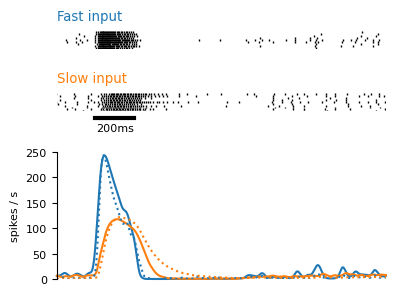

In [17]:
fig, axes = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1,1,6]}, figsize=(4,3))

axes[0].eventplot(list(res_fast[5].values()), color='black', lw=1)
axes[1].eventplot(list(res_slow[2].values()), color='black', lw=1)

axes[0].set_title('Fast input', loc='left', color='C0')
axes[1].set_title('Slow input', loc='left', color='C1')

axes[1].plot([2,2.2], [-3.5,-3.5], clip_on=False, color='black', lw=3)
axes[1].text(2.2, -10, '200ms', ha='right')

ax = axes[2]

mask = (tarr > 1.8) & (tarr < 3.5)

ax.plot(tarr[mask], np.mean(kdes_trials_fast, axis=0)[mask], clip_on=False)
ax.plot(tarr[mask], np.mean(kdes_trials_slow, axis=0)[mask], clip_on=False)
ax.set_ylim(0, 250)

# ax.plot([2.2,2.3],[200,200], lw=2, color='black')
# ax.text(2.25, 210, '100ms', ha='center', va='top')

ax.plot(tarr_stim+2, stim_arr_fast, color='C0', linestyle='dotted')
ax.plot(tarr_stim+2, stim_arr_slow, color='C1', linestyle='dotted')

ax.set_ylabel('spikes / s')

despine_ax(ax, where='b')

for ax in axes:
    ax.set_xlim(1.8, 3.5)
    
for ax in axes[:2]:
    ax.set_ylim(0, 11)
    despine_ax(ax)
    
plt.tight_layout()

# plt.savefig('img/slow_fast_pn_input.png')